In [1]:
from __future__ import print_function, division
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
# Defines a ECG dataset
class ECGDataset(Dataset):
    def __init__(self, file):
        self.data = np.loadtxt(f"datasets/{file}.csv", delimiter=',', dtype=np.float32, skiprows=0)
        self.ecgs = torch.Tensor(self.data[:, 1:])
        self.labels = torch.Tensor(self.data[:, [0]])

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return((self.ecgs[idx], float(self.labels[idx])))

In [3]:
# Loads data into an ECGDataset object
train = ECGDataset("train")
test = ECGDataset("test/full")

# Loads data into a torch dataloader object
trainset = torch.utils.data.DataLoader(train, batch_size=16, shuffle=True)
testset = torch.utils.data.DataLoader(test, batch_size=16, shuffle=False)

In [12]:
# Defines network architecture
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(6000, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 256)
        self.fc5 = nn.Linear(256, 1)

    def forward(self, x):
        x = F.gelu(self.fc1(x))
        x = F.gelu(self.fc2(x))
        x = F.gelu(self.fc3(x))
        x = F.gelu(self.fc4(x))
        x = torch.sigmoid(self.fc5(x))
        
        return(x)

        
net = Net()
print(net)

Net(
  (fc1): Linear(in_features=6000, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=256, bias=True)
  (fc5): Linear(in_features=256, out_features=1, bias=True)
)


In [13]:
# Defines the mean-squared-error loss function
def MSE(data, target):
    cost = 0
    for i in range(len(data)):
        cost += (abs(data[i]) - abs(target[i])) ** 2
        
    return cost

In [14]:
# Defines the mean-absolute-error loss function
def MAE(data, target):
    cost = 0
    for i in range(len(data)):
        cost += abs(abs(data[i]) - abs(target[i]))
        
    return cost

In [15]:
# Defines wether or not the program will log the test and training loss
# Note: extremly inefficent and drasticlly increases compute time.
LOG_TEST_LOSS = False
LOG_TRAIN_LOSS = False

if LOG_TRAIN_LOSS:
    train_loss = []
    
if LOG_TEST_LOSS:
    test_loss = []

In [16]:
# Defines the number of epochs, or iterations over training data
EPOCHS = 6

# optimizer
optimizer = optim.Adam(net.parameters(), lr=0.0005)

In [17]:
count = 0
for epoch in range(EPOCHS):
    for data in trainset:
        net.zero_grad()
        X, y = data
        output = net(X.view(-1, 6000))
        loss = MSE(output, y)
        loss.backward()
        optimizer.step()
        
        if LOG_TRAIN_LOSS:
            with torch.no_grad():
                errors = 0
                for data in trainset:
                    X, y = data
                    output = net(X.view(-1, 6000))
                    errors += MAE(output, y) / len(output)

                train_loss.append(errors / len(trainset))

        if LOG_TEST_LOSS:
            with torch.no_grad():
                errors = 0
                for data in testset:
                    X, y = data
                    output = net(X.view(-1, 6000))
                    errors += MAE(output, y) / len(output)

                test_loss.append(errors / len(testset))

        count += 1

        if count % 32 == 0:
            print(f"{round(count * 100 / (len(trainset) * EPOCHS), 2)}% Completed")
            
print("100% Completed")

1.86% Completed
3.73% Completed
5.59% Completed
7.46% Completed
9.32% Completed
11.19% Completed
13.05% Completed
14.92% Completed
16.78% Completed
18.65% Completed
20.51% Completed
22.38% Completed
24.24% Completed
26.11% Completed
27.97% Completed
29.84% Completed
31.7% Completed
33.57% Completed
35.43% Completed
37.3% Completed
39.16% Completed
41.03% Completed
42.89% Completed
44.76% Completed
46.62% Completed
48.48% Completed
50.35% Completed
52.21% Completed
54.08% Completed
55.94% Completed
57.81% Completed
59.67% Completed
61.54% Completed
63.4% Completed
65.27% Completed
67.13% Completed
69.0% Completed
70.86% Completed
72.73% Completed
74.59% Completed
76.46% Completed
78.32% Completed
80.19% Completed
82.05% Completed
83.92% Completed
85.78% Completed
87.65% Completed
89.51% Completed
91.38% Completed
93.24% Completed
95.1% Completed
96.97% Completed
98.83% Completed
100% Completed


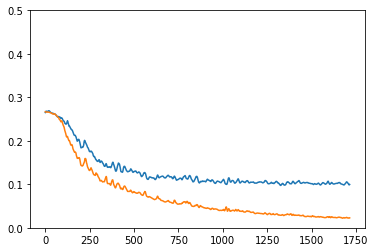

In [25]:
if LOG_TRAIN_LOSS and LOG_TEST_LOSS:
    plt.ylim(0, 0.5)
    plt.plot(list(test_loss))
    plt.plot(list(train_loss))

elif LOG_TEST_LOSS:
    plt.ylim(0, 0.5)
    plt.plot(list(test_loss))

elif LOG_TRAIN_LOSS:
    plt.ylim(0, 0.5)
    plt.plot(list(train_loss))

In [18]:
# Prints out info
error = 0
samples = 0
total = 0
expected_total = 0
mse = 0

with torch.no_grad():
    for data in trainset:
        X, y = data
        output = net(X.view(-1, 6000))
        
        for i in range(len(output)):
            error += abs(abs(float(output[i])) - abs(float(y[i])))
            mse += (abs(float(output[i])) - abs(float(y[i]))) ** 2
            total += float(output[i])
            expected_total += float(y[i])
            samples += 1


print(f"Average error: +-{round(float(error / samples), 5)}")
print(f"MSE: {mse}")
print(f"avg MSE: {mse / samples}")
print(f"Average answer: {total / samples}")
print(f"Expected average: {expected_total / samples}")

Average error: +-0.02101
MSE: 3.9701209028155726
avg MSE: 0.0008689255641968861
Average answer: 0.4965253227872827
Expected average: 0.49432374558353037


In [19]:
# Prints out info
import time

error = 0
samples = 0
total = 0
expected_total = 0
mse = 0

start_time = time.time()

with torch.no_grad():
    for data in testset:
        X, y = data
        output = net(X.view(-1, 6000))
        
        for i in range(len(output)):
            error += abs(abs(float(output[i])) - abs(float(y[i])))
            mse += (abs(float(output[i])) - abs(float(y[i]))) ** 2
            total += float(output[i])
            expected_total += float(y[i])
            samples += 1

time = round(time.time() - start_time, 4)

print(f"Average error: +-{round(float(error / samples), 5)}")
print(f"std. dev: {(mse / samples) ** 0.5}")
print(f"MSE: {mse}")
print(f"variance: {mse / samples}")
print(f"Average answer: {total / samples}")
print(f"Expected average: {expected_total / samples}")
print(f"Test execution took: {time} seconds")

Average error: +-0.09143
std. dev: 0.13150878262926505
MSE: 9.94437194746299
variance: 0.017294559908631286
Average answer: 0.5353294394715973
Expected average: 0.5640043741982916
Test execution took: 0.0888 seconds
